In [53]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from shapely.geometry import LineString, Point
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [161]:
'''

This script is meant to take in data exported from OVITO and analyze the displaced particles, count the number of vacancies
present within the crystal sample, measure the track length, calculate the theoretical vacancy density as a function of 
depth into the crystal, and find the track width as a function of track depth into the sample. 

This notebook is a continuous work in progress, and especially the proposed methodology to find the track width may need \
to be modified in the future.

Currently to calculate the number of vacancies we say that it is a 1:1 relationship with the number of displaced atoms, which 
is what we are specifically examining in the code below. 

To find the vacancy density as a function of depth, we take volume slices perpendicular to the direction of the inbound gold
ion and count the number of vacancies in this rectangular region over many different depth options. The starting and ending
points of these rectangles are easily modifiable by changing the starting and ending values in the function input.

To find the track width, we first specify along which axis we want to find the track width and then about the 0-point which the
gold ion was initially shot in on (for example at x = 0 or x = 10 or y = 20) for a particular depth we do a complete 360 degree
rotation about the other two axes and find the atoms which have the shortest radius at that particular point (with a specified 
small tolerance value). The values returned are the predicted radii, so we multiply the answer by 2 in the final plot.

***This is open to being modified since this was a rudimentary idea.***

@author: kmream


'''

'\n\nThis script is meant to take in data exported from OVITO and analyze the displaced particles, count the number of vacancies\npresent within the crystal sample, measure the track length, calculate the theoretical vacancy density as a function of \ndepth into the crystal, and find the track width as a function of track depth into the sample. \n\nThis notebook is a continuous work in progress, and especially the proposed methodology to find the track width may need to be modified in the future.\n\nCurrently to calculate the number of vacancies we say that it is a 1:1 relationship with the number of displaced atoms, which \nis what we are specifically examining in the code below. \n\nTo find the vacancy density as a function of depth, we take volume slices perpendicular to the direction of the inbound gold\nion and count the number of vacancies in this rectangular region over many different depth options. The starting and ending\npoints of these rectangles are easily modifiable by cha

### Step 1: Get Data Loaded and Visualized

In [92]:
# read in the data 
paths = [
    '6_18_2025_runs/6_18_2025_19000_6pico_100kev',
    '6_19_2025_runs/6_19_2025_15000_100keV_50pico',
    '6_23_2025_runs/6_23_2025_20000_100keV_20pico',
    '6_24_2025_runs/6_24_2025_25000_100keV_10pico',
    '6_4_2025_runs/6_5_2025_10keV_15000_7pico'
]

seeds = ['19000', '15000', '20000', '25000', '15000']

def clean_and_convert(path, header="id type x y z step coordination\n"):
    """
    Cleans a text file by removing non-data lines, writes a header, and returns a DataFrame
    with converted x, y, z values (from Å to nm), and a list of unique timesteps.
    """
    # Step 1: Clean file
    with open(path, 'r') as infile:
        lines = infile.readlines()

    clean_lines = [header]
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 7 and parts[0].isdigit():
            clean_lines.append(line)

    with open(path, 'w') as outfile:
        outfile.writelines(clean_lines)

    df = pd.read_csv(path, sep=r"\s+")
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']] / 10.0
    steps = df['step'].unique()

    return df, steps

data_1, steps1 = clean_and_convert(paths[0])
data_2, steps2 = clean_and_convert(paths[1])
data_3, steps3 = clean_and_convert(paths[2])
data_4, steps4 = clean_and_convert(paths[3])
data_5, steps5 = clean_and_convert(paths[4])

def remove_data(data):
 #   data = data[data['y'] < 11.925]

    return data

data_1, data_2, data_3, data_4, data_5 = remove_data(data_1), remove_data(data_2), remove_data(data_3), remove_data(data_4), remove_data(data_5)

### Visualize the damage, comparing different parameters or seeds against one another.

(-18.3137, 14.7016)

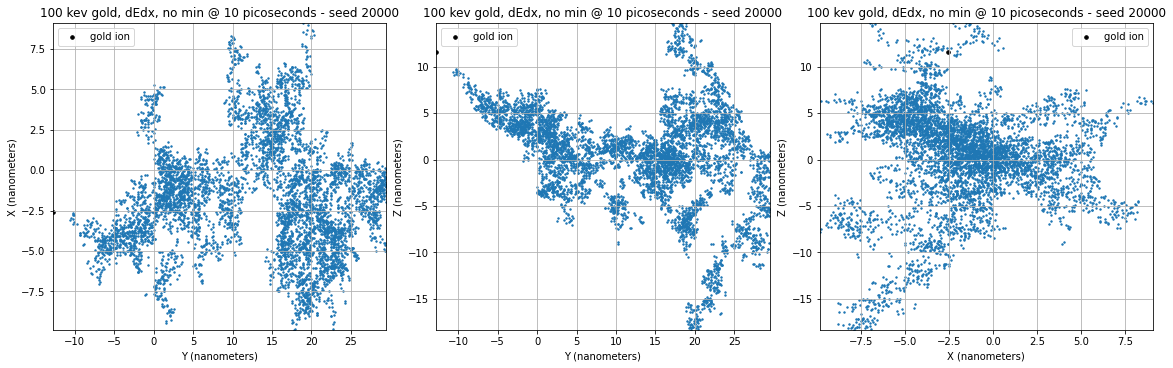

In [99]:
# Original data
kev = 100
num_sec = 10
data_list = [data_1, data_2, data_3, data_4, data_5]

dataframe = 3
data = data_list[dataframe - 1]

gold_type = 3
crystal_type = "quartz"
ion_type = "gold"

x_min, x_max = data['x'].min(), data['x'].max()
y_min, y_max = data['y'].min(), data['y'].max()
z_min, z_max = data['z'].min(), data['z'].max()

num_vacancies1 = [len(data_1[data_1['step'] == step]) for step in steps1]
num_vacancies2 = [len(data_2[data_2['step'] == step]) for step in steps2]
num_vacancies3 = [len(data_3[data_3['step'] == step]) for step in steps3]
num_vacancies4 = [len(data_4[data_4['step'] == step]) for step in steps4]
num_vacancies5 = [len(data_5[data_5['step'] == step]) for step in steps5]

######################################################################################

fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

axes[0].scatter(data['y'].values, data['x'].values, s = 8, marker = '.')
axes[0].scatter(data[data['type'] == gold_type]['y'].values, data[data['type'] == gold_type]['x'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[0].set_title(f'{kev} kev {ion_type}, dEdx, no min @ {num_sec} picoseconds - seed {seeds[dataframe-1]}')
axes[0].set_xlabel('Y (nanometers)')
axes[0].set_ylabel('X (nanometers)')
axes[0].legend(loc = 'best')
axes[0].grid(True)
axes[0].set_xlim(y_min, y_max)
axes[0].set_ylim(x_min, x_max)

axes[1].scatter(data['y'].values, data['z'].values, s = 8, marker = '.')
axes[1].scatter(data[data['type'] == gold_type]['y'].values, data[data['type'] == gold_type]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[1].set_title(f'{kev} kev {ion_type}, dEdx, no min @ {num_sec} picoseconds - seed {seeds[dataframe-1]}')
axes[1].set_xlabel('Y (nanometers)')
axes[1].set_ylabel('Z (nanometers)')
axes[1].legend(loc = 'best')
axes[1].grid(True)
axes[1].set_xlim(y_min, y_max)
axes[1].set_ylim(z_min, z_max)

axes[2].scatter(data['x'].values, data['z'].values, s = 8, marker = '.')
axes[2].scatter(data[data['type'] == gold_type]['x'].values, data[data['type'] == gold_type]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[2].set_title(f'{kev} kev {ion_type}, dEdx, no min @ {num_sec} picoseconds - seed {seeds[dataframe-1]}')
axes[2].set_xlabel('X (nanometers)')
axes[2].set_ylabel('Z (nanometers)')
axes[2].legend(loc = 'best')
axes[2].grid(True)
axes[2].set_xlim(x_min, x_max)
axes[2].set_ylim(z_min, z_max)

### Step 2: Find vacancy density in one specific region

In [82]:
# units of dimensions are in angstroms
x_len1 = np.max(data_1['x'].values) - np.min(data_1['x'].values)
y_len1 = np.max(data_1['y'].values) - np.min(data_1['y'].values)
z_len1 = np.max(data_1['z'].values) - np.min(data_1['z'].values)

x_len2 = np.max(data_2['x'].values) - np.min(data_2['x'].values)
y_len2 = np.max(data_2['y'].values) - np.min(data_2['y'].values)
z_len2 = np.max(data_2['z'].values) - np.min(data_2['z'].values)

x_len3 = np.max(data_3['x'].values) - np.min(data_3['x'].values)
y_len3 = np.max(data_3['y'].values) - np.min(data_3['y'].values)
z_len3 = np.max(data_3['z'].values) - np.min(data_3['z'].values)

x_len4 = np.max(data_4['x'].values) - np.min(data_4['x'].values)
y_len4 = np.max(data_4['y'].values) - np.min(data_4['y'].values)
z_len4 = np.max(data_4['z'].values) - np.min(data_4['z'].values)

x_len5 = np.max(data_5['x'].values) - np.min(data_5['x'].values)
y_len5 = np.max(data_5['y'].values) - np.min(data_5['y'].values)
z_len5 = np.max(data_5['z'].values) - np.min(data_5['z'].values)

volume1, volume2 = ((x_len1) * (y_len1) * (z_len1)), ((x_len2) * (y_len2) * (z_len2))
volume3, volume4, volume5 = ((x_len3) * (y_len3) * (z_len3)), ((x_len4) * (y_len4) * (z_len4)), ((x_len5) * (y_len5) * (z_len5))

In [83]:
''' basic generalized formula as of this moment to find vacancy density at a particular slice from yz-plane of desired thickness '''

def vacancy_vs_depth(data, start, end, one_len, two_len): #this works best for one timestep - can modify in the future if needed
    depth = start - end #starting and ending points specified, where start here is specified as the entrance on the right side
    vol = depth * one_len * two_len  # this takes into account a slice of the entire yz-plane at some depth in the x-direction
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result

In [84]:
x_start1, x_end1 = np.max(data_1['x'].values), np.min(data_1['x'].values)
y_start1, y_end1 = np.max(data_1['y'].values), np.min(data_1['y'].values)
z_start1, z_end1 = np.max(data_1['z'].values), np.min(data_1['z'].values)
data_input1 = data_1[data_1['step'] == steps1[0]]

x_start2, x_end2 = np.max(data_2['x'].values), np.min(data_2['x'].values)
y_start2, y_end2 = np.max(data_2['y'].values), np.min(data_2['y'].values)
z_start2, z_end2 = np.max(data_2['z'].values), np.min(data_2['z'].values)
data_input2 = data_2[data_2['step'] == steps2[0]]

x_start3, x_end3 = np.max(data_3['x'].values), np.min(data_3['x'].values)
y_start3, y_end3 = np.max(data_3['y'].values), np.min(data_3['y'].values)
z_start3, z_end3 = np.max(data_3['z'].values), np.min(data_3['z'].values)
data_input3 = data_3[data_3['step'] == steps3[0]]

x_start4, x_end4 = np.max(data_4['x'].values), np.min(data_4['x'].values)
y_start4, y_end4 = np.max(data_4['y'].values), np.min(data_4['y'].values)
z_start4, z_end4 = np.max(data_4['z'].values), np.min(data_4['z'].values)
data_input4 = data_4[data_4['step'] == steps4[0]]

x_start5, x_end5 = np.max(data_5['x'].values), np.min(data_5['x'].values)
y_start5, y_end5 = np.max(data_5['y'].values), np.min(data_5['y'].values)
z_start5, z_end5 = np.max(data_5['z'].values), np.min(data_5['z'].values)
data_input5 = data_5[data_5['step'] == steps5[0]]

### Step 3: Make a plot for differing depths what are the predicted vacancy densities (with error to be added soon)

In [85]:
x_end_options = [.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0]
y_end_options = [-12, -10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
z_end_options = [-10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 2.5, 2.75, 3.0]

result1 = [vacancy_vs_depth(data_input1, y_start1, y, x_len1, z_len1) for y in y_end_options]
result2 = [vacancy_vs_depth(data_input2, y_start2, y, x_len2, z_len2) for y in y_end_options]
result3 = [vacancy_vs_depth(data_input3, y_start3, y, x_len3, z_len3) for y in y_end_options]
result4 = [vacancy_vs_depth(data_input4, y_start4, y, x_len4, z_len4) for y in y_end_options]
result5 = [vacancy_vs_depth(data_input5, y_start5, y, x_len5, z_len5) for y in y_end_options]

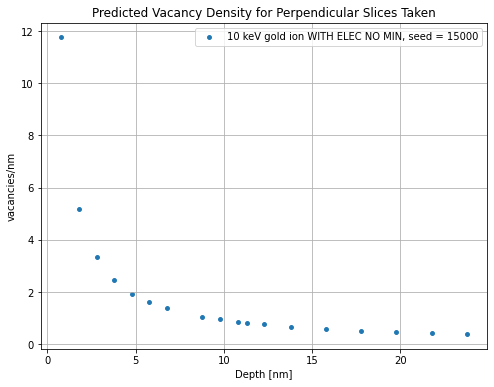

In [86]:
plt.figure(figsize=(8, 6))

y_values1, y_values2 = [y_start1 - y for y in y_end_options], [y_start2 - y for y in y_end_options]
y_values3, y_values4, y_values5 = [y_start3 - y for y in y_end_options], [y_start4 - y for y in y_end_options], [y_start5 - y for y in y_end_options]

# plt.scatter(y_values1, result1, label = f'10 keV gold ion NO ELEC, seed = {seeds[0]}', s = 15)
# plt.scatter(y_values_elec_1, result_elec_1, label = f'10 keV gold ion WITH ELEC, seed = {seeds[0]}', s = 15)

# plt.scatter(y_values2, result2, label = f'10 keV gold ion NO ELEC, seed = {seeds[1]}', s = 15)
# plt.scatter(y_values_elec_2, result_elec_2, label = f'10 keV gold ion WITH ELEC, seed = {seeds[1]}', s = 15)

# plt.scatter(y_values3, result3, label = f'10 keV gold ion NO ELEC, seed = {seeds[2]}', s = 15)
# plt.scatter(y_values_elec_3, result_elec_3, label = f'10 keV gold ion WITH ELEC, seed = {seeds[2]}', s = 15)

# plt.scatter(y_values4, result4, label = f'10 keV gold ion NO ELEC, seed = {seeds[3]}', s = 15)
# plt.scatter(y_values_elec_4, result_elec_4, label = f'10 keV gold ion WITH ELEC, seed = {seeds[3]}', s = 15)

plt.scatter(y_values5, result5, label = f'10 keV gold ion WITH ELEC NO MIN, seed = {seeds[4]}', s = 15)

plt.title(f'Predicted Vacancy Density for Perpendicular Slices Taken')
plt.xlabel('Depth [nm]')
plt.ylabel('vacancies/nm')
plt.legend(loc = 'best')
plt.grid(True)

### Step 4: Subtract the displaced atoms from the original configuration to visualize what the created track would more realistically look like! Use PCA analysis to determine the direction of the track and other important features such as different moments. 

In [95]:
def clean_compare_and_convert(data_path, original_path, header="id type x y z step coordination\n"):
    
    '''

    this function loads in the data, cleans it such that the units are in nm, and determines where the original vacancy sites were for the respective interstitial atoms

    '''

    with open(data_path, 'r') as infile:
        lines = infile.readlines()
    clean_lines = [header]
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 7 and parts[0].isdigit():
            clean_lines.append(line)
    with open(data_path, 'w') as outfile:
        outfile.writelines(clean_lines)

    # Step 2: Clean original file
    with open(original_path, 'r') as infile:
        lines = infile.readlines()
    clean_lines2 = [header]
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 7 and parts[0].isdigit():
            clean_lines2.append(line)
    with open(original_path, 'w') as outfile:
        outfile.writelines(clean_lines2)

    # Step 3: Load CSVs
    data = pd.read_csv(data_path, sep=r"\s+")
    original = pd.read_csv(original_path, sep=r"\s+")

    expected_cols = ['id', 'type', 'x', 'y', 'z', 'step', 'coordination']
    data.columns = expected_cols
    original.columns = expected_cols

    # Step 4: Ensure IDs are numeric
    data['id'] = pd.to_numeric(data['id'], errors='coerce').astype('Int64')
    original['id'] = pd.to_numeric(original['id'], errors='coerce').astype('Int64')

    data_ids = data['id'].dropna().values
    original_ids = original['id'].dropna().values

    modified_ids = np.setdiff1d(original_ids, data_ids)
    vacancy_ids = np.intersect1d(original_ids, data_ids)

    modified = original[original['id'].isin(modified_ids)].copy()
    vacancies = original[original['id'].isin(vacancy_ids)].copy()

    for df in [modified, vacancies]:
        df[['x', 'y', 'z']] = df[['x', 'y', 'z']].apply(pd.to_numeric, errors='coerce')
        df[['x', 'y', 'z']] = df[['x', 'y', 'z']] / 10.0

    return modified, vacancies

original_crystal_paths = [
    "6_18_2025_runs/6_18_2025_19000_100kev_original",
    "6_19_2025_runs/6_19_2025_15000_original",
    "6_23_2025_runs/6_23_2025_20000_original",
    "6_24_2025_runs/6_24_2025_25000_original",
    "6_4_2025_runs/6_5_2025_15000_original"
]

mods = []
vacancies = []

for path, original_path in zip(paths, original_crystal_paths):
    mod_df, vac_df = clean_compare_and_convert(path, original_path)
    mods.append(mod_df)
    vacancies.append(vac_df)

mod_1, vacancies_1 = clean_compare_and_convert(paths[0], original_crystal_paths[0])
mod_2, vacancies_2 = clean_compare_and_convert(paths[1], original_crystal_paths[1])
mod_3, vacancies_3 = clean_compare_and_convert(paths[2], original_crystal_paths[2])
mod_4, vacancies_4 = clean_compare_and_convert(paths[3], original_crystal_paths[3])
mod_5, vacancies_5 = clean_compare_and_convert(paths[4], original_crystal_paths[4])

In [104]:
##### CALCULATE DIRECTION OF TRACK USING PCA

def pca_calculation(data, shooting = 'y'):

    '''

    This function uses principal component analysis to calculate the direction of the damage track in the planes perpendicular to the ion's motion. This is best used when the 
    ion's trajectory is overlayed on the combination plot. This will also be used as an input into the track width and length finder algorithm, to ensure these are being calculated 
    properly vs assuming the track will remain perfectly horizontal about the axis which the ion was shot in at. There is an option to choose which axis the ion is shot along to 
    easily modify the calculations. 

    '''

    #first convert data into proper format:
    data = data.loc[:, ['x', 'y', 'z']]
    data_array = np.array(data)
    if shooting == 'x':
        origin = np.array([float(np.max(data_array[:, 1])), 0, 0])
    elif shooting == 'y':
        origin = np.array([0, float(np.max(data_array[:, 1])), 0]) 
    elif shooting == 'z': 
        origin = np.array([0, 0, float(np.max(data_array[:, 1]))]) 
    
    positions_centered = data_array - origin

    pca = PCA(n_components=3)
    pca.fit(positions_centered)
    direction = pca.components_[0]

    dot = np.dot(direction, direction_vector)
    if dot < 0:
        direction = -direction

    dir_xy = direction[:2]
    dir_yz = direction[1:]
    dir_xz = [direction[0], direction[2]]

    print(direction)

    return origin, dir_xy, dir_yz, dir_xz

[-0.00354621 -0.97774944  0.20974618]


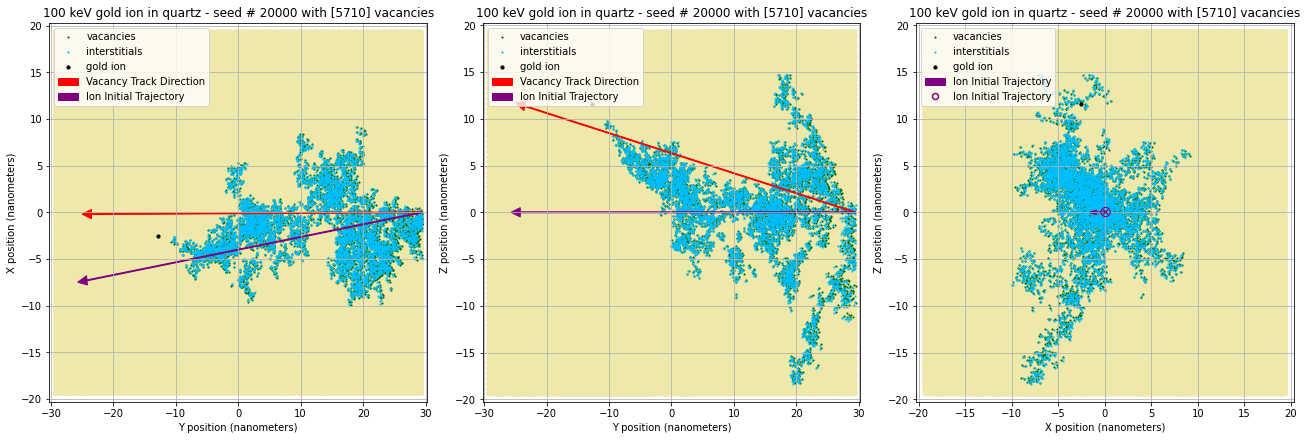

In [224]:
# visualize the resulting damage similar to above
mod_data = [mod_1, mod_2, mod_3, mod_4, mod_5]
vacancies = [vacancies_1, vacancies_2, vacancies_3, vacancies_4, vacancies_5]
original_data = [data_1, data_2, data_3, data_4, data_5]
num_vacancies = [num_vacancies1, num_vacancies2, num_vacancies3, num_vacancies4, num_vacancies5]

x_min = min(df['x'].min() for df in mod_data)
x_max = max(df['x'].max() for df in mod_data)
y_min = min(df['y'].min() for df in mod_data)
y_max = max(df['y'].max() for df in mod_data)
z_min = min(df['z'].min() for df in mod_data)
z_max = max(df['z'].max() for df in mod_data)

direction_vector = np.array([np.cos(np.radians(90+7.8)), np.cos(np.radians(180)), np.cos(np.radians(90))]) 
direction_vector = direction_vector / np.linalg.norm(direction_vector)

######################################################################################

def plot_damage(ax, mod, vac, orig, seed, num_vac, axis1, axis2, axis_labels, limits,
                origin=None, direction=None, arrow_scale=10, title_suffix=""):
    ax.scatter(mod[axis1], mod[axis2], s=1, marker='.', color='palegoldenrod', alpha=0.45)
    ax.scatter(vac[axis1], vac[axis2], s=5, marker='.', color='darkgreen', label='vacancies')
    ax.scatter(orig[axis1], orig[axis2], s=5, marker='.', color='deepskyblue', label='interstitials')
    ax.scatter(orig[orig['type'] == gold_type][axis1], orig[orig['type'] == gold_type][axis2], 
               s=40, color='black', marker='.', label='gold ion')

    custom_symbol = None
    
    if origin is not None:
        idx1 = ['x', 'y', 'z'].index(axis1)
        idx2 = ['x', 'y', 'z'].index(axis2)

        start_x = origin[idx1]
        start_y = origin[idx2]

        # === PCA Direction Arrow (Red) ===
        dx_pca = direction[0] * arrow_scale
        dy_pca = direction[1] * arrow_scale
        if (axis1, axis2) == ('y', 'x'):
            # Flip x and y for this axis order
            dx_pca, dy_pca = dy_pca, dx_pca

        if (axis1, axis2) in [('y', 'x'), ('y', 'z')]:
            ax.arrow(start_x, start_y, dx_pca, dy_pca, color='red', width=0.1, head_width=1.0, label='Vacancy Track Direction')
            arrow_end = (start_x + dx_pca, start_y + dy_pca)
        else:
            arrow_end = None 

        # === Given Track Direction Arrow (Purple) ===
        dx_given = direction_vector[idx1] * arrow_scale
        dy_given = direction_vector[idx2] * arrow_scale
        
        if (axis1, axis2) == ('x', 'z'):
            ax.text(start_x, start_y, '⊗', fontsize=16, ha='center', va='center', color='purple') 
            short_scale = arrow_scale * 0.125 
            dx_short = direction_vector[idx1] * short_scale
            dy_short = direction_vector[idx2] * short_scale

            ax.arrow(start_x, start_y, dx_short, dy_short, color='purple', width=0.1, head_width=0.5, label='Ion Initial Trajectory')
            custom_symbol = Line2D([0], [0], marker='o', linestyle='None', color='purple', markeredgewidth=1.5,
                       markerfacecolor='white', markeredgecolor='purple', label='Ion Initial Trajectory')

            handles, labels = ax.get_legend_handles_labels()
            handles.append(custom_symbol)
            labels.append('Ion Initial Trajectory (into page)')
            ax.legend(handles=handles, labels=labels, loc='upper left')
            
            
        else: 
            ax.arrow(start_x, start_y, dx_given, dy_given, color='purple', width=0.1, head_width=1.0, label='Ion Initial Trajectory')
            arrow_end2 = (start_x + dx_given, start_y + dy_given)

    handles, labels = ax.get_legend_handles_labels()
    if custom_symbol is not None:
        handles.append(custom_symbol)
        labels.append(custom_symbol.get_label())

    ax.legend(handles=handles, labels=labels, loc='upper left')

    ax.set_title(f'{kev} keV {ion_type} ion in {crystal_type} - seed # {seed} with {num_vac} vacancies{title_suffix}')
    ax.set_xlabel(f"{axis_labels[0]} position (nanometers)")
    ax.set_ylabel(f"{axis_labels[1]} position (nanometers)")
    ax.grid(True)
    ax.set_xlim(*limits[axis1])
    ax.set_ylim(*limits[axis2])

    return arrow_end

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
dataframe = 3

limits = {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}
axis_pairs = [('y', 'x'), ('y', 'z'), ('x', 'z')]
axis_labels = {'x': 'X', 'y': 'Y', 'z': 'Z'}

range_x = x_max - x_min
range_y = y_max - y_min
range_z = z_max - z_min
arrow_scale = 0.65 * np.sqrt(range_x**2 + range_y**2 + range_z**2)

# Calculate PCA origin and directions once for the dataframe
origin, dir_xy, dir_yz, dir_xz = pca_calculation(original_data[dataframe - 1], shooting='y')

directions = {
    ('y','x'): dir_xy,
    ('y','z'): dir_yz,
    ('x','z'): dir_xz
}

arrow_endpoints = {}

for idx, (axis1, axis2) in enumerate(axis_pairs):
    end_point = plot_damage(ax=axes[idx], mod=mod_data[dataframe - 1], vac=vacancies[dataframe - 1], orig=original_data[dataframe - 1], seed=seeds[dataframe - 1], 
                num_vac=num_vacancies[dataframe - 1], axis1=axis1, axis2=axis2, axis_labels=(axis_labels[axis1], axis_labels[axis2]), limits=limits, origin=origin, 
        direction=directions[(axis1, axis2)], arrow_scale = arrow_scale)
    arrow_endpoints[(axis1, axis2)] = end_point

#grabbing the endpoint of the arrow to get the line endpoints such that when we calculate the length/width it is done over this particular line
valid_endpoints = [pt for pt in arrow_endpoints.values() if pt is not None]
endpoints_array = np.array(valid_endpoints)

yx = endpoints_array[0]  # (y, x)
yz = endpoints_array[1]  # (y, z)
x_from_yx, y_from_yx, z_from_yz = yx[1], yx[0], yz[1]
endpoint_3d = np.array([x_from_yx, y_from_yx, z_from_yz]) 

In [210]:
# look into the moments or head and tail effects of the tracks or more int/vacancies on one side of the track vs other side - PCA can quantify this stuff

### Step 5: Calculate the track width and length.

In [211]:
# === Setup ===
tolerance = 0.1 #this is the tolerance of the gaussian circle, in nm
def gaussian_circ(a, b, origin, radius):
    a = np.asarray(a)
    b = np.asarray(b)
    dist_sq = (a - origin[0])**2 + (b - origin[1])**2
    r_sq = radius**2

    mask = np.abs(dist_sq - r_sq) <= tolerance
    points = np.column_stack((a[mask], b[mask]))

    return points

depth_tol = 0.5 #this is the tolerance of the plane slice being taken, so the width of the plane slice (+- this value)
end_radius = 20 # in nm
beginning_radius = 1
radii = np.linspace(beginning_radius, end_radius, 401)   #note the lowest this will be will change 
delta = tolerance # kind of like a radial smoothing filter 
data, vac = data_list[dataframe - 1], vacancies[dataframe - 1]

# === Generate line points along the ion track ===
n_steps = 1001
t_vals = np.linspace(0, 1, n_steps)
start = origin
end = endpoint_3d
track_vec = end - start
track_unit = track_vec / np.linalg.norm(track_vec)
line_points = np.outer(1 - t_vals, start) + np.outer(t_vals, end)

all_results = {}
max_density = 0
max_info = {'depth': None, 'radius': None}

# === Loop over each point on the track ===
for point in line_points:
    # Relative vectors from each atom to current point
    vac_vectors = vac[['x', 'y', 'z']].values - point
    int_vectors = data[['x', 'y', 'z']].values - point

    # Project onto track to get depth along track direction
    vac_depths = np.dot(vac_vectors, track_unit)
    int_depths = np.dot(int_vectors, track_unit)

    # Select atoms close to this depth slice (± depth_tol)
    vac_plane_pts = vac_vectors[np.abs(vac_depths) <= depth_tol]
    int_plane_pts = int_vectors[np.abs(int_depths) <= depth_tol]

    # Project into plane: remove parallel component
    vac_perp = vac_plane_pts - np.outer(np.dot(vac_plane_pts, track_unit), track_unit)
    int_perp = int_plane_pts - np.outer(np.dot(int_plane_pts, track_unit), track_unit)

    # Get radial distances in that plane
    vac_radii = np.linalg.norm(vac_perp, axis=1)
    int_radii = np.linalg.norm(int_perp, axis=1)

    results = []
    zero_streak = 0

    for r in radii:
        count_vac_total, count_int_total = 0, 0

        for dr in [-delta, 0, delta]:
            r_adj = r + dr
            band_min = r_adj - tolerance
            band_max = r_adj + tolerance

            vac_mask = (vac_radii >= band_min) & (vac_radii <= band_max)
            int_mask = (int_radii >= band_min) & (int_radii <= band_max)

            count_vac_total += np.sum(vac_mask)
            count_int_total += np.sum(int_mask)

        avg_vac = count_vac_total / 3
        avg_int = count_int_total / 3

        if avg_vac == 0 and avg_int == 0:
            zero_streak += 1
            continue
        else:
            zero_streak = 0

        results.append({
            'radius': r,
            'avg_vacancies': avg_vac,
            'avg_interstitials': avg_int
        })

        total_density = avg_vac + avg_int
        if total_density > max_density:
            max_density = total_density
            max_info = {'depth': tuple(point), 'radius': r}

    if results:
        all_results[tuple(point)] = results

At y-position 17.136 nm/depth 12.63 nm into the quartz is where the maximum damage width point is located.
The length of the track created by the gold ion in quartz at 100 keV is 43.290 nm.
The average radial track damage created by the gold ion in quartz at 100 keV is 11.294 nm.


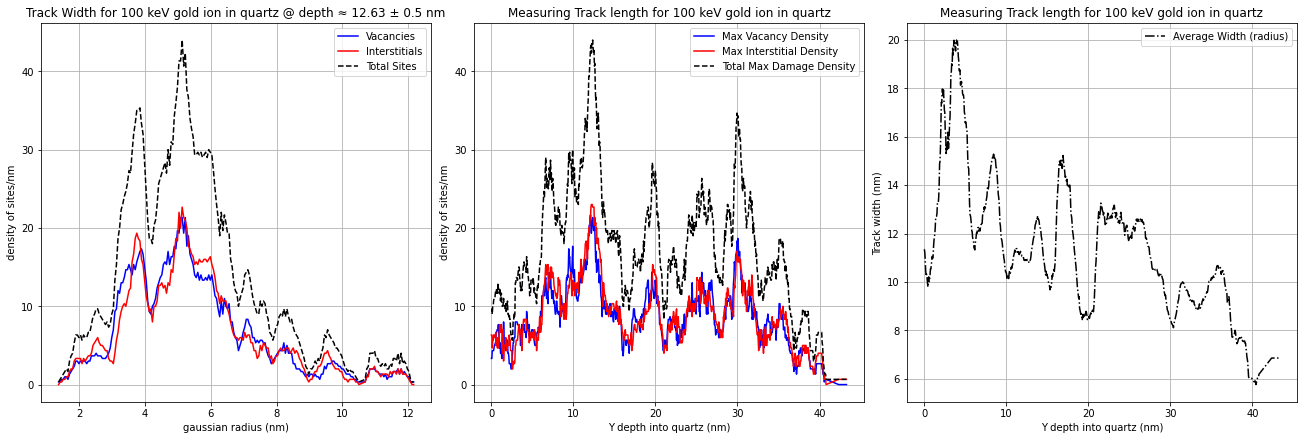

In [212]:
best_depth = max_info['depth']
best_results = all_results[best_depth]
radii_best = [d['radius'] for d in best_results]
vac_best = [d['avg_vacancies'] for d in best_results]
int_best = [d['avg_interstitials'] for d in best_results]
total_best = [v + i for v, i in zip(vac_best, int_best)]


#information to calculate the track length
depths = []
max_vac_densities = []
max_int_densities = []
max_total_densities = []
avg_widths = []

for depth, results_list in all_results.items():
    max_entry = max(results_list, key=lambda d: d['avg_vacancies'] + d['avg_interstitials'])
    
    depths.append(depth)
    max_vac_densities.append(max_entry['avg_vacancies'])
    max_int_densities.append(max_entry['avg_interstitials'])
    max_total_densities.append(max_entry['avg_vacancies'] + max_entry['avg_interstitials'])
    
    # == getting the average width at each depth value ==
    
    results = all_results[depth]
    radii_slice = np.array([r['radius'] for r in results])
    total_density = np.array([r['avg_vacancies'] + r['avg_interstitials'] for r in results])

    if total_density.sum() > 0:
        weighted_avg_radius = np.sum(radii_slice * total_density) / np.sum(total_density)
        weighted_avg_radius = weighted_avg_radius + weighted_avg_radius
    else:
        weighted_avg_radius = 0

    avg_widths.append(weighted_avg_radius)


depth_scalar = np.dot(np.array(best_depth) - origin, track_unit)
depths_numeric = [d[1] if isinstance(d, (tuple, list)) else d for d in depths]

depth_into_crystal = np.abs(depths_numeric - depths_numeric[0])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)


axes[0].plot(radii_best, vac_best, label='Vacancies', color = 'blue')
axes[0].plot(radii_best, int_best, label='Interstitials', color = 'red')
axes[0].plot(radii_best, total_best, label = 'Total Sites', color = 'black', linestyle = '--')
axes[0].set_title(f'Track Width for {kev} keV {ion_type} ion in {crystal_type} @ depth ≈ {depth_scalar:.2f} ± {depth_tol} nm')
axes[0].set_xlabel('gaussian radius (nm)')
axes[0].set_ylabel('density of sites/nm')
axes[0].legend(loc = 'best')
axes[0].grid(True)

axes[1].plot(depth_into_crystal, max_vac_densities, label='Max Vacancy Density', color='blue')
axes[1].plot(depth_into_crystal, max_int_densities, label='Max Interstitial Density', color='red')
axes[1].plot(depth_into_crystal, max_total_densities, label='Total Max Damage Density', color='black', linestyle='--')
axes[1].set_title(f'Measuring Track length for {kev} keV {ion_type} ion in {crystal_type}')
axes[1].set_xlabel(f'Y depth into {crystal_type} (nm)')
axes[1].set_ylabel('density of sites/nm')
axes[1].legend(loc='best')
axes[1].grid(True)

axes[2].plot(depth_into_crystal, avg_widths, label='Average Width (radius)', color = 'black', linestyle='-.')
axes[2].set_title(f'Measuring Track length for {kev} keV {ion_type} ion in {crystal_type}')
axes[2].set_xlabel(f'Y depth into {crystal_type} (nm)')
axes[2].set_ylabel('Track width (nm)')
axes[2].legend(loc='best')
axes[2].grid(True)

print(f"At y-position {max_info['depth'][1]:.3f} nm/depth {depth_scalar:.2f} nm into the quartz is where the maximum damage width point is located.")
print(f"The length of the track created by the {ion_type} ion in {crystal_type} at {kev} keV is {np.abs(depths_numeric[0] - depths_numeric[-1]):.3f} nm.")
print(f"The average radial track damage created by the {ion_type} ion in {crystal_type} at {kev} keV is {np.mean(avg_widths):.3f} nm.")

In [131]:
n_depths = 100
t_depths = np.linspace(0.1, 1, n_depths)
start = origin
end = endpoint_3d
track_vec = end - start
track_unit = track_vec / np.linalg.norm(track_vec)

depth_points = np.outer(1 - t_depths, start) + np.outer(t_depths, end)

all_results = {}
max_density = 0
max_info = {'depth': None, 'radius': None}

for point in depth_points:
    # Relative vectors from each atom to current depth point
    vac_vectors = vac[['x', 'y', 'z']].values - point
    int_vectors = data[['x', 'y', 'z']].values - point

    # Project atom positions onto track direction (scalar depth)
    vac_depths = np.dot(vac_vectors, track_unit)
    int_depths = np.dot(int_vectors, track_unit)

    # Select atoms close to current depth slice ± depth_tol
    vac_slice_mask = np.abs(vac_depths) <= depth_tol
    int_slice_mask = np.abs(int_depths) <= depth_tol

    vac_slice = vac_vectors[vac_slice_mask]
    int_slice = int_vectors[int_slice_mask]

    # Remove parallel component to get transverse 2D plane coords
    vac_perp = vac_slice - np.outer(np.dot(vac_slice, track_unit), track_unit)
    int_perp = int_slice - np.outer(np.dot(int_slice, track_unit), track_unit)

    # Extract transverse x and z coords (or any two orthogonal axes)
    vac_xz = vac_perp[:, [0, 2]]
    int_xz = int_perp[:, [0, 2]]

    results = []
    zero_streak = 0

    for r in radii:
        count_vac_total = 0
        count_int_total = 0
        vac_counts = []
        int_counts = []

        for dr in [-delta, 0, delta]:
            r_adj = r + dr
            # Count points in annulus r_adj ± tolerance using gaussian_circ logic
            vac_points_found = gaussian_circ(vac_xz[:,0], vac_xz[:,1], origin=[0,0], radius=r_adj)
            int_points_found = gaussian_circ(int_xz[:,0], int_xz[:,1], origin=[0,0], radius=r_adj)

            count_vac_total += len(vac_points_found)
            count_int_total += len(int_points_found)

            vac_counts.append(len(vac_points_found))
            int_counts.append(len(int_points_found))

        avg_vac = count_vac_total / 3
        avg_int = count_int_total / 3

        std_vac = np.std(vac_counts, ddof=1) if len(vac_counts) > 1 else 0
        std_int = np.std(int_counts, ddof=1) if len(int_counts) > 1 else 0
        std_total = np.sqrt(std_vac**2 + std_int**2)  # propagate error assuming independence

        if avg_vac == 0 and avg_int == 0:
            zero_streak += 1
            if zero_streak >= 10:
                break  # stop iterating larger radii when counts zero for 10 steps
            continue
        else:
            zero_streak = 0

        results.append({
            'radius': r,
            'avg_vacancies': avg_vac,
            'avg_interstitials': avg_int,
            'avg_totalpoints': avg_vac + avg_int,
            'std_vacancies': std_vac,
            'std_interstitials': std_int,
            'std_totalpoints': std_total,
        })

        total_density = avg_vac + avg_int
        if total_density > max_density:
            max_density = total_density
            max_info = {'depth': tuple(point), 'radius': r}

    if results:
        all_results[tuple(point)] = results

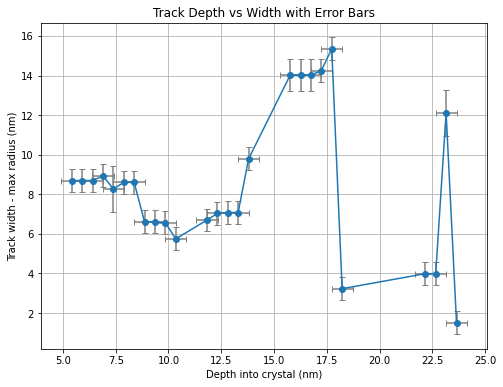

In [70]:
depths = []
max_radii = []
std_errors = []

plt.figure(figsize=(8, 6))

for point in depth_points:
    results = all_results.get(tuple(point), [])
    if not results:
        continue

    valid_results = [r for r in results if r['avg_totalpoints'] > 0]
    if not valid_results:
        continue

    max_entry = valid_results[-1]
    max_radii.append(max_entry['radius'])
    std_errors.append(max_entry['std_totalpoints'])

    depth = np.dot(point - start, track_unit)
    depths.append(depth)

h_error = np.full_like(depths, depth_tol)


plt.errorbar(depths, max_radii, xerr=h_error, yerr=std_errors, fmt='o-', ecolor='gray', capsize=3)
plt.xlabel('Depth into crystal (nm)')
plt.ylabel('Track width - max radius (nm)')
plt.title('Track Depth vs Width with Error Bars')
plt.grid(True)

### Step 6: Analyze the statistics over different runs. 

In [202]:
def analyze_stats(n, *inputs):
    """
    This function takes in an integer n that corresponds to the number of dataframes inputted, 
    and various inputs starting with all of the inputted dataframes and following with desired 
    other inputs such as the saved track lengths in the previous cell. The function then analyzes 
    the statistics of these inputs and computes the mean, median, variance, and standard deviation 
    values for all inputs loaded in.

    ORDER OF STATS PRINTED:
    1) Vacancy information - first load in dataframes
    2) Total damage track depths - second load in track depth information
    3) Gold track depth - third load in gold track depth information
    """

    print(f"Processing {n} runs")

    vacancy_counts, tot_tracks, gold_tracks = [], [], []

    dfs = inputs[:n]
    #tot_track = inputs[n:2*n]
    #gold_track = inputs[2*n:3*n]

    for i, df in enumerate(dfs):
        print(f"DataFrame {i+1} shape: {df.shape}")  

        # grab number of vacancies from each dataframe
        first_step = df['step'].iloc[0]
        num_vacancies = len(df[df['step'] == first_step])
        print(f"Run {i+1} had {num_vacancies} total vacancies")
        vacancy_counts.append(num_vacancies)

    # find stats on the vacancies
    mean_val = np.mean(vacancy_counts)
    median_val = np.median(vacancy_counts)
    variance_val = np.var(vacancy_counts)  
    std_val = np.std(vacancy_counts) 

    # find stats on track lengths and track widths
    track_lens = [37.820, 36.111, 43.290]#, 11.93]
    track_widths = [7.407 * 2, 7.302 * 2, 5.647 * 2]

    mean_len, median_len, variance_len, std_len = np.mean(track_lens), np.median(track_lens), np.var(track_lens), np.std(track_lens)
    mean_width, median_width, variance_width, std_width = np.mean(track_widths), np.median(track_widths), np.var(track_widths), np.std(track_widths)


    print(f"\nSummary statistics across {n} runs with different seeds:\n")
    print(f"Mean # vac: {mean_val:.2f}; Median of vac: {median_val:.2f}; Variance: {variance_val:.1f} vac^2; STD: {std_val:.1f} vac")
    print(f"Mean track length: {mean_len:.2f} nm; Median track length: {median_len:.2f} nm; Variance: {variance_len:.1f} nm^2; STD: {std_len:.1f} nm")
    print(f"Mean radial track damage: {mean_width:.2f} nm; Median radial track damage: {median_width:.2f} nm; Variance: {variance_width:.1f} nm^2 ; STD: {std_width:.1f} nm\n")


In [203]:
num_dfs = 3
analyze_stats(num_dfs, data_1, data_2, data_3)#, data_4, data_5)

Processing 3 runs
DataFrame 1 shape: (5593, 7)
Run 1 had 5593 total vacancies
DataFrame 2 shape: (5759, 7)
Run 2 had 5759 total vacancies
DataFrame 3 shape: (5710, 7)
Run 3 had 5710 total vacancies

Summary statistics across 3 runs with different seeds:

Mean # vac: 5687.33; Median of vac: 5710.00; Variance: 4849.6 vac^2; STD: 69.6 vac
Mean track length: 39.07 nm; Median track length: 37.82 nm; Variance: 9.4 nm^2; STD: 3.1 nm
Mean radial track damage: 13.57 nm; Median radial track damage: 14.60 nm; Variance: 2.6 nm^2 ; STD: 1.6 nm



### Step 7: See how the number of vacancies varies over the entire simulation.

In [113]:
num_cols = 3 #number of columns exported from OVITO for this portion

def clean_data(input_path, output_path, header="id type step count\n"):
    '''
    reads and removes any portions of text in outputted file from OVITO over multiple frames that looks like the following:

    97
    Frame 1 cell_orig -52.862753 -200.0 -115.597917 cell_vec1 105.725506 0.0 0.0 cell_vec2 0.0 600.0 0.0 cell_vec3 0.0 0.0 231.195834 pbc 1 0 1
    '''

    count = 0
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        outfile.write(header)
        for line in infile:
            parts = line.strip().split()
            if len(parts) >= num_cols and parts[0].isdigit():
                outfile.write(line)
                count += 1

dataframe = 3
date = 23
input_path, output_path = f'6_{date}_2025_runs/6_{date}_2025_{seeds[dataframe - 1]}_numvacancyinfo', f'6_{date}_2025_runs/6_{date}_2025_{seeds[dataframe - 1]}_numvacancyinfo_clean'
clean_data(input_path, output_path)

In [114]:
clean_1 = pd.read_csv('6_18_2025_runs/6_18_2025_19000_numvacancyinfo_clean', sep = " ")
clean_2 = pd.read_csv('6_19_2025_runs/6_19_2025_15000_numvacancyinfo_clean', sep = " ")
clean_3 = pd.read_csv('6_23_2025_runs/6_23_2025_20000_numvacancyinfo_clean', sep = " ")
clean_4 = pd.read_csv('6_24_2025_runs/6_24_2025_25000_numvacancyinfo_clean', sep = " ")
clean_5 = pd.read_csv('6_4_2025_runs/6_5_2025_15000_numvacancyinfo_clean', sep = " ")

def summarize_counts(data):
    steps = np.unique(data['step'].values)

    counts = []

    for step in steps:
        count = len(data[data['step'] == step])
        counts.append(count)
    return steps, counts

counts_1 = summarize_counts(clean_1)
counts_2 = summarize_counts(clean_2)
counts_3 = summarize_counts(clean_3)
counts_4 = summarize_counts(clean_4)
counts_5 = summarize_counts(clean_5)

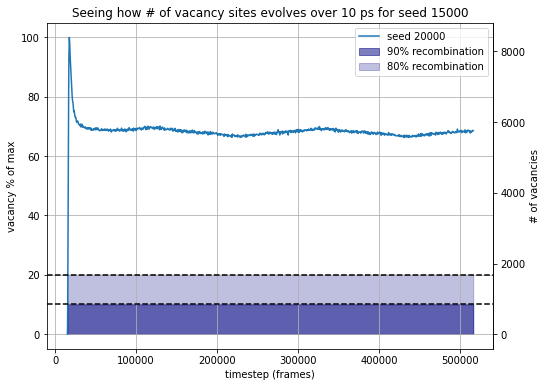

In [226]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

counts_list = [counts_1, counts_2, counts_3, counts_4, counts_5]
dataframe = 2
counts = counts_list[dataframe - 1]

actual_vals = counts[1]
y_vals = normalize(actual_vals) * 100  
ten_percent, twenty_percent = 10, 20

fig, ax = plt.subplots(figsize=(8, 6))

num_sec = 10

ax.plot(counts[0], y_vals, label=f'seed {seeds[dataframe]}')
ax.axhline(y=ten_percent, color='black', linestyle='--')
ax.axhline(y=twenty_percent, color='black', linestyle='--')
ax.fill_between(counts[0], 0, ten_percent, alpha=0.5, color='navy', label="90% recombination")
ax.fill_between(counts[0], 0, twenty_percent, alpha=0.25, color='navy', label="80% recombination")
ax.set_ylabel('vacancy % of max')
ax.set_xlabel('timestep (frames)')
ax.set_title(f'Seeing how # of vacancy sites evolves over {num_sec} ps for seed {seeds[dataframe - 1]}')
ax.grid(True)

def percent_to_actual(percent):
    return percent / 100 * (np.max(actual_vals) - np.min(actual_vals)) + np.min(actual_vals)

def actual_to_percent(actual):
    return (actual - np.min(actual_vals)) / (np.max(actual_vals) - np.min(actual_vals)) * 100

ax2 = ax.secondary_yaxis('right', functions=(percent_to_actual, actual_to_percent))
ax2.set_ylabel('# of vacancies')
ax.legend(loc='best')
